In [57]:
# Imports & readDataSubset()
import pandas as pd
import numpy as np
import pyarrow.dataset as pads
from SMT_Data_Starter_2025 import readDataSubset
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# Load fonts
font_path = r"C:\Users\mla21\AppData\Local\Microsoft\Windows\Fonts\Helvetica.ttf"
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Helvetica'

# Just get the subsets out of the way
game_info_subset = readDataSubset('game_info')
game_events_subset = readDataSubset('game_events')
player_position_subset = readDataSubset('player_pos')
ball_position_subset = readDataSubset('ball_pos')

In [58]:
"""Analysis.ipynb


1. Load datasets & models
2. Calculate baseline Pr(Safe)
    (I.e. Take 1st baseman out of the equation)
    Using catch_probability model
    Using catch_timestamp model
    Using safe_probability model
3. Get "would be" times for effort levels
    (I.e. E[ft_til_1st(_itsx)|effort])
    (Simulate running attempts & contests)
    Using max_acc_cap model
    Using effort model
4. Calculate Pr(Safe) based on "would be" times (median effort)
    Using catch_probability model
    Using safe_probability model
5. Calculate Pr(Safe) based on "would be" times (max effort)
    Using catch_probability model
    Using safe_probability model
X. (Put everything together)
6. Calculate SPA


 

"""
pass

In [59]:
"""
Load datasets & models
    1. Load datasets
    2. Load max_acc_cap ensemble (from Running.ipynb)
    3. Load effort model (from Running.ipynb)
    4. Load catch_probability ensemble (from ResultProbs.ipynb)
        (With optimal weights)
    5. Load catch_timestamp ensemble (from ResultProbs.ipynb)
    6. Load safe_probability model (from CatchResults.ipynb)

"""
import pickle
import xgboost as xgb
import catboost as cat
import lightgbm as lgb
from Helpers import Ensemble

## 1. Load datasets
running_hustle = pd.read_csv('../CSV/running_hustle.csv')
ball_plane_run = pd.read_csv('../CSV/ball_plane_run_clean.csv')

## 2. Load max_acc_cap ensemble (from Running.ipynb)
TOP_0 = 1000
max_acc_cap_models = []
for i in range(TOP_0):
    model = cat.CatBoostRegressor()
    model.load_model(f'../Models/max_acc_cap_models/max_acc_cap_model_catboost_{i}')
    max_acc_cap_models.append(model)
max_acc_cap_ensemble = Ensemble([max_acc_cap_models[i] for i in range(TOP_0)])

## 3. Load effort model (coefficients) (from Running.ipynb)
with open('../Models/effort_model_coeffs.pkl', 'rb') as f:
    effort_model_coeffs = pickle.load(f)

## 4. Load catch_probability ensemble (from ResultProbs.ipynb)
TOP_1 = 1
catch_probability_xgb_models = []
catch_probability_cat_models = []
catch_probability_lgb_models = []
for i in range(TOP_1):
    xgb_model = xgb.Booster(model_file=f'../Models/catch_probability_models/catch_probability_model_xgboost_{i}')
    catch_probability_xgb_models.append(xgb_model)
    cat_model = cat.CatBoostClassifier()
    cat_model.load_model(f'../Models/catch_probability_models/catch_probability_model_catboost_{i}')
    catch_probability_cat_models.append(cat_model)
    lgb_model = lgb.Booster(model_file=f'../Models/catch_probability_models/catch_probability_model_lightgbm_{i}') 
    catch_probability_lgb_models.append(lgb_model)
xgb_ensemble = Ensemble([catch_probability_xgb_models[i] for i in range(TOP_1)])
cat_ensemble = Ensemble([catch_probability_cat_models[i] for i in range(TOP_1)])
lgb_ensemble = Ensemble([catch_probability_lgb_models[i] for i in range(TOP_1)])
# Load optimal weights (list)
with open('../Models/catch_probability_optimal_weights.pkl', 'rb') as f:
    optimal_weights = pickle.load(f)

## 5. Load catch_timestamp ensemble (from ResultProbs.ipynb)
TOP_2 = 1000
catch_timestamp_models = []
for i in range(TOP_2):
    model = cat.CatBoostRegressor()
    model.load_model(f'../Models/catch_timestamp_models/catch_timestamp_model_catboost_{i}')
    catch_timestamp_models.append(model)
catch_timestamp_ensemble = Ensemble([catch_timestamp_models[i] for i in range(TOP_2)])

## 5. Load safe_probability model (from CatchResults.ipynb)
with open('../Models/safe_probability_model.pkl', 'rb') as f:
    safe_probability_model = pickle.load(f)

## 5. Load catchoff safe_probability model (from ResultProbs.ipynb)
with open('../Models/safe_probability_catchoff_model.pkl', 'rb') as f:
    safe_probability_catchoff_model = pickle.load(f)

In [60]:
running_hustle.head(1)

,game_str,play_id,batter,hand,contact_ts,startrun_ts,time_to_run,ttr_cutoff,time_lost,timestamp,ft_til_1st_sm,spd_to_1st_sm,acc_to_1st_sm,spd_sm_mapsoft_theta,acc_5to10_95th,effort_percent,hustle_plus
0,y1_d001_CGA_QEA,21.0,CGA-1824,R,560499.0,560749.0,250.0,250.0,0.0,560749,91.276741,5.896027,18.429326,29.039858,23.519888,79.874426,105.354295


In [61]:
ball_plane_run.head(1)

,game_str,play_id,nth_throw,safe,advanced,thr_ts,acq_ts,arr_ts,closest_itsx_ts,E_itsx_ts,E_ft_til_1st_itsx,ft_til_1st,itsx_catch_ts_delta,plane_orientation_polar,plane_orientation_azimuth,ball_norm_x_plane,ball_dis_plane_origin,proj_ball_z,ball_direction_polar,ball_direction_azimuth
0,y1_d001_CGA_QEA,21,2,True,False,563799,563149.0,564699.0,564599,564599.774035,0.9762,-1.802771,99.225965,135.692773,2.823368,0.333805,6.875793,6.894816,-51.920797,-6.292179


In [62]:
"""
Calculate baseline Pr(Safe)
    (I.e. Take 1st baseman out of the equation)
    Using catch_probability model
    Using catch_timestamp model
    Using safe_probability model
    1. Calculate p(CatchOn|throw)
    2. Calculate E[catch_timing|throw]
    3. Estimate ft_til_1st at catch_timing
    4. Calculate Pr(Safe)
    5. Get time saved by 1st baseman
"""
baseline = ball_plane_run.copy()

## 1. Calculate p(CatchOn|throw)
X = baseline[xgb_ensemble.models[0].feature_names]
y_prob_ensemble = (xgb_ensemble.predict_proba(X)*optimal_weights[0] + 
                   cat_ensemble.predict_proba(X)*optimal_weights[1] + 
                   lgb_ensemble.predict_proba(X)*optimal_weights[2])
baseline['pr_CatchOn']  = [lst[0] for lst in y_prob_ensemble]
baseline['pr_CatchOff'] = [lst[1] for lst in y_prob_ensemble]
baseline['pr_Dropped']  = [lst[2] for lst in y_prob_ensemble]
baseline['pr_Passed']   = [lst[3] for lst in y_prob_ensemble]

## 2. Calculate E[catch_timing|throw]
baseline['E_itsx_catch_ts_delta'] = catch_timestamp_ensemble.predict(X)
baseline['E_catch_ts'] = baseline['E_itsx_ts'] + baseline['E_itsx_catch_ts_delta']

## 3. Estimate ft_til_1st at catch_timing
# Get spd_to_1st_sm at closest timestamp before catch
closest_spd = running_hustle[['game_str','play_id','timestamp','ft_til_1st_sm','spd_to_1st_sm']]
baseline = baseline.merge(closest_spd,how='left',on=['game_str','play_id'])
baseline['ts_diff'] = baseline['timestamp'] - baseline['E_catch_ts']
baseline = baseline[baseline['ts_diff'] <= 0]
baseline = baseline.sort_values(by=['game_str','play_id','timestamp']).drop_duplicates(subset=['game_str','play_id'], keep='last')
# Assume speed stays constant
baseline['E_ft_til_1st_catch'] = (
    baseline['ft_til_1st_sm'] + baseline['spd_to_1st_sm'] * baseline['ts_diff'] / 1000)  # ms to s

## 4. Calculate Pr(Safe)
X = baseline[['E_ft_til_1st_catch']].rename(columns={'E_ft_til_1st_catch':'ft_til_1st'})
baseline['pr_safe_given_CatchOn'] = safe_probability_model.predict_proba(X)[:,-1]
baseline['pr_safe_baseline'] = 1 - baseline['pr_CatchOn'] * (1-baseline['pr_safe_given_CatchOn'])

## 5. Get time saved by 1st baseman
baseline['stretch_by_1st_saved_ms'] = baseline['arr_ts'] - baseline['E_catch_ts']
baseline.loc[baseline['pr_CatchOn'] < 0.1, 'stretch_by_1st_saved_ms'] = np.nan

## X. Organize
baseline = baseline[['game_str','play_id','E_itsx_ts','E_catch_ts','pr_safe_baseline','stretch_by_1st_saved_ms']]
baseline.head(1)

,game_str,play_id,E_itsx_ts,E_catch_ts,pr_safe_baseline,stretch_by_1st_saved_ms
77,y1_d001_CGA_QEA,21,564599.774035,564683.850158,0.99818,15.149842


In [63]:
"""
Get "would be" times for effort levels
    (I.e. E[ft_til_1st(_itsx)|effort])
    (Simulate running attempts & contests)
    Using max_acc_cap model
    Using effort model
    1. Get initial positions
    2. Get "would be" time
    3. Compute (This takes 10+ hours)
"""
# from joblib import Parallel, delayed
# from tqdm import tqdm

# ## 1. Get initial positions
# initial = running_hustle[['game_str','play_id','timestamp','startrun_ts','time_lost',
#                           'spd_sm_mapsoft_theta','acc_5to10_95th','ft_til_1st_sm','spd_to_1st_sm']].copy()
# initial['shouldstartrun_ts'] = running_hustle['startrun_ts'] - running_hustle['time_lost']
# initial = initial[initial['shouldstartrun_ts'] == initial['timestamp']]
# initial = initial.dropna(subset=['spd_sm_mapsoft_theta','acc_5to10_95th'])

# ## 2. Get "would be" time
# def get_wouldbe_ft_til_1st(row, option: str, effort_level, interval_ms=50):
#     spd_to_1st_sm = row['spd_to_1st_sm']
#     ft_til_1st_sm = row['ft_til_1st_sm']
#     destination_ts = row['E_itsx_ts'] if option=='itsx' else row['E_catch_ts']
#     ts = row['timestamp']
#     force_perc = min(100, np.polyval(effort_model_coeffs, effort_level) * (1))
#     while ts + interval_ms < destination_ts:
#         # Get next ft_til_1st
#         ft_til_1st_sm -= spd_to_1st_sm*interval_ms/1000
#         # Predict acceleration
#         X = pd.DataFrame([{'spd_to_1st_sm': spd_to_1st_sm,
#                            'spd_sm_mapsoft_theta': row['spd_sm_mapsoft_theta'],
#                            'acc_5to10_95th': row['acc_5to10_95th']}])
#         max_acc_cap = max_acc_cap_ensemble.predict(X)
#         pred_acc = max_acc_cap - row['acc_5to10_95th'] + force_perc*row['acc_5to10_95th']
#         # Get next speed using acceleration
#         spd_to_1st_sm += pred_acc*interval_ms/1000
#         ts += interval_ms
#     if ts + interval_ms >= destination_ts:  # Must be true
#         shortened_interval = ts + interval_ms - destination_ts
#         ft_til_1st_sm -= spd_to_1st_sm*shortened_interval/1000
#     return ft_til_1st_sm
# # Get E_itsx_ts & E_catch_ts
# initial = initial.merge(baseline[['game_str','play_id','E_itsx_ts','E_catch_ts']],
#                         how='inner',on=['game_str','play_id'])

# ## 3. Compute (This takes 10+ hours)
# runtypes = {
#             'wouldbe_ft_til_1st_itsx_ifmax': ('itsx', 1.00),
#             'wouldbe_ft_til_1st_itsx_ifmed': ('itsx', 0.8385),
#             'wouldbe_ft_til_1st_itsx_ifmean': ('itsx', 0.7582),
#             'wouldbe_ft_til_1st_catch_ifmax':('catch',1.00),
#             'wouldbe_ft_til_1st_catch_ifmed':('catch',0.8385),
#             'wouldbe_ft_til_1st_catch_ifmean':('catch',0.7582)}
# for col_name, (opt, eff) in runtypes.items():
#     progressbar = tqdm(initial.iterrows(), total=len(initial), desc=col_name)
#     initial[col_name] = Parallel(n_jobs=-1)(
#         delayed(get_wouldbe_ft_til_1st)(row, option=opt, effort_level=eff)
#         for _, row in progressbar)
# # Organize
# # (The values are listed for some reason)
# initial['wouldbe_ft_til_1st_itsx_ifmax'] = initial['wouldbe_ft_til_1st_itsx_ifmax'].apply(lambda x: x[0]).astype(np.float32)
# initial['wouldbe_ft_til_1st_itsx_ifmed'] = initial['wouldbe_ft_til_1st_itsx_ifmed'].apply(lambda x: x[0]).astype(np.float32)
# initial['wouldbe_ft_til_1st_itsx_ifmean'] = initial['wouldbe_ft_til_1st_itsx_ifmean'].apply(lambda x: x[0]).astype(np.float32)
# initial['wouldbe_ft_til_1st_catch_ifmax'] = initial['wouldbe_ft_til_1st_catch_ifmax'].apply(lambda x: x[0]).astype(np.float32)
# initial['wouldbe_ft_til_1st_catch_ifmed'] = initial['wouldbe_ft_til_1st_catch_ifmed'].apply(lambda x: x[0]).astype(np.float32)
# initial['wouldbe_ft_til_1st_catch_ifmean'] = initial['wouldbe_ft_til_1st_catch_ifmean'].apply(lambda x: x[0]).astype(np.float32)

## X. Save
# wouldbe = initial.copy()
# wouldbe.to_csv('../CSV/wouldbe.csv', index=False)   

'\nGet "would be" times for effort levels\n    (I.e. E[ft_til_1st(_itsx)|effort])\n    (Simulate running attempts & contests)\n    Using max_acc_cap model\n    Using effort model\n    1. Get initial positions\n    2. Get "would be" time\n    3. Compute (This takes 10+ hours)\n'

In [64]:
## X. Load saved file for brevity
wouldbe = pd.read_csv('../CSV/wouldbe.csv')
wouldbe.head(1)

,game_str,play_id,timestamp,startrun_ts,time_lost,spd_sm_mapsoft_theta,acc_5to10_95th,ft_til_1st_sm,spd_to_1st_sm,shouldstartrun_ts,E_itsx_ts,E_catch_ts,wouldbe_ft_til_1st_itsx_ifmax,wouldbe_ft_til_1st_itsx_ifmed,wouldbe_ft_til_1st_catch_ifmax,wouldbe_ft_til_1st_catch_ifmed,wouldbe_ft_til_1st_itsx_ifmean,wouldbe_ft_til_1st_catch_ifmean
0,y1_d001_CGA_QEA,21.0,560749,560749.0,0.0,29.039858,23.519888,91.276741,5.896027,560749.0,564599.774035,564681.403546,-4.404517,2.110627,-4.961859,1.588369,4.927117,4.492168


In [76]:
"""
Calculate Pr(Safe) based on "would be" times (max effort)
    Using catch_probability model
    Using safe_probability model
    1. Calculate p(CatchOn|throw)
    2. Calculate Pr(Safe)
"""
# Load data
wouldbe_max = wouldbe[['game_str','play_id','wouldbe_ft_til_1st_itsx_ifmax','wouldbe_ft_til_1st_catch_ifmax']].copy()
mask = ['game_str','play_id','E_itsx_ts','E_ft_til_1st_itsx'] + xgb_ensemble.models[0].feature_names
wouldbe_max = pd.merge(wouldbe_max, ball_plane_run[mask], how='inner', on=['game_str','play_id'])
wouldbe_max = wouldbe_max.drop(columns=['E_ft_til_1st_itsx'])
wouldbe_max = wouldbe_max.rename(columns={'wouldbe_ft_til_1st_itsx_ifmax':'E_ft_til_1st_itsx',
                                          'wouldbe_ft_til_1st_catch_ifmax':'ft_til_1st'})

## 1. Calculate p(CatchOn|throw)
X = wouldbe_max[xgb_ensemble.models[0].feature_names]
y_prob_ensemble = (xgb_ensemble.predict_proba(X)*optimal_weights[0] + 
                   cat_ensemble.predict_proba(X)*optimal_weights[1] + 
                   lgb_ensemble.predict_proba(X)*optimal_weights[2])
wouldbe_max['pr_CatchOn']  = [lst[0] for lst in y_prob_ensemble]
wouldbe_max['pr_CatchOff'] = [lst[1] for lst in y_prob_ensemble]
wouldbe_max['pr_Dropped']  = [lst[2] for lst in y_prob_ensemble]
wouldbe_max['pr_Passed']   = [lst[3] for lst in y_prob_ensemble]

## 2. Calculate Pr(Safe)
X = wouldbe_max[['ft_til_1st']]
wouldbe_max['pr_safe_given_CatchOn'] = safe_probability_model.predict_proba(X)[:,-1]
wouldbe_max['pr_safe_given_CatchOff'] = safe_probability_catchoff_model.predict_proba(X)[:,-1]
wouldbe_max['pr_safe_wouldbe_max'] = (1 - 
                                      wouldbe_max['pr_CatchOn'] * (1-wouldbe_max['pr_safe_given_CatchOn']) - 
                                      wouldbe_max['pr_CatchOff'] * (1-wouldbe_max['pr_safe_given_CatchOff']))

# X. Organize
wouldbe_max = wouldbe_max.drop(columns=xgb_ensemble.models[0].feature_names)
wouldbe_max = wouldbe_max[['game_str','play_id','pr_safe_wouldbe_max']]
wouldbe_max.head(1)

,game_str,play_id,pr_safe_wouldbe_max
0,y1_d001_CGA_QEA,21.0,0.999985


In [75]:
"""
Calculate Pr(Safe) based on "would be" times (median effort)
    Using catch_probability model
    Using safe_probability model
    1. Calculate p(CatchOn|throw)
    2. Calculate Pr(Safe)
"""
# Load data
wouldbe_med = wouldbe[['game_str','play_id','wouldbe_ft_til_1st_itsx_ifmed','wouldbe_ft_til_1st_catch_ifmed']].copy()
mask = ['game_str','play_id','E_itsx_ts','E_ft_til_1st_itsx'] + xgb_ensemble.models[0].feature_names
wouldbe_med = pd.merge(wouldbe_med, ball_plane_run[mask], how='inner', on=['game_str','play_id'])
wouldbe_med = wouldbe_med.drop(columns=['E_ft_til_1st_itsx'])
wouldbe_med = wouldbe_med.rename(columns={'wouldbe_ft_til_1st_itsx_ifmed':'E_ft_til_1st_itsx',
                                          'wouldbe_ft_til_1st_catch_ifmed':'ft_til_1st'})

## 1. Calculate p(CatchOn|throw)
X = wouldbe_med[xgb_ensemble.models[0].feature_names]
y_prob_ensemble = (xgb_ensemble.predict_proba(X)*optimal_weights[0] + 
                   cat_ensemble.predict_proba(X)*optimal_weights[1] + 
                   lgb_ensemble.predict_proba(X)*optimal_weights[2])
wouldbe_med['pr_CatchOn']  = [lst[0] for lst in y_prob_ensemble]
wouldbe_med['pr_CatchOff'] = [lst[1] for lst in y_prob_ensemble]
wouldbe_med['pr_Dropped']  = [lst[2] for lst in y_prob_ensemble]
wouldbe_med['pr_Passed']   = [lst[3] for lst in y_prob_ensemble]

## 2. Calculate Pr(Safe)
X = wouldbe_med[['ft_til_1st']]
wouldbe_med['pr_safe_given_CatchOn'] = safe_probability_model.predict_proba(X)[:,-1]
wouldbe_med['pr_safe_given_CatchOff'] = safe_probability_catchoff_model.predict_proba(X)[:,-1]
wouldbe_med['pr_safe_wouldbe_med'] = (1 - 
                                      wouldbe_med['pr_CatchOn'] * (1-wouldbe_med['pr_safe_given_CatchOn']) - 
                                      wouldbe_med['pr_CatchOff'] * (1-wouldbe_med['pr_safe_given_CatchOff']))

# X. Organize
wouldbe_med = wouldbe_med.drop(columns=xgb_ensemble.models[0].feature_names)
wouldbe_med = wouldbe_med[['game_str','play_id','pr_safe_wouldbe_med']]
wouldbe_med.head(1)

,game_str,play_id,pr_safe_wouldbe_med
0,y1_d001_CGA_QEA,21.0,0.935293


In [77]:
"""
Calculate Pr(Safe) based on "would be" times (mean effort)
    Using catch_probability model
    Using safe_probability model
    1. Calculate p(CatchOn|throw)
    2. Calculate Pr(Safe)
"""
# Load data
wouldbe_mean = wouldbe[['game_str','play_id','wouldbe_ft_til_1st_itsx_ifmean','wouldbe_ft_til_1st_catch_ifmean']].copy()
mask = ['game_str','play_id','E_itsx_ts','E_ft_til_1st_itsx'] + xgb_ensemble.models[0].feature_names
wouldbe_mean = pd.merge(wouldbe_mean, ball_plane_run[mask], how='inner', on=['game_str','play_id'])
wouldbe_mean = wouldbe_mean.drop(columns=['E_ft_til_1st_itsx'])
wouldbe_mean = wouldbe_mean.rename(columns={'wouldbe_ft_til_1st_itsx_ifmean':'E_ft_til_1st_itsx',
                                          'wouldbe_ft_til_1st_catch_ifmean':'ft_til_1st'})

## 1. Calculate p(CatchOn|throw)
X = wouldbe_mean[xgb_ensemble.models[0].feature_names]
y_prob_ensemble = (xgb_ensemble.predict_proba(X)*optimal_weights[0] + 
                   cat_ensemble.predict_proba(X)*optimal_weights[1] + 
                   lgb_ensemble.predict_proba(X)*optimal_weights[2])
wouldbe_mean['pr_CatchOn']  = [lst[0] for lst in y_prob_ensemble]
wouldbe_mean['pr_CatchOff'] = [lst[1] for lst in y_prob_ensemble]
wouldbe_mean['pr_Dropped']  = [lst[2] for lst in y_prob_ensemble]
wouldbe_mean['pr_Passed']   = [lst[3] for lst in y_prob_ensemble]

## 2. Calculate Pr(Safe)
X = wouldbe_mean[['ft_til_1st']]
wouldbe_mean['pr_safe_given_CatchOn'] = safe_probability_model.predict_proba(X)[:,-1]
wouldbe_mean['pr_safe_given_CatchOff'] = safe_probability_catchoff_model.predict_proba(X)[:,-1]
wouldbe_mean['pr_safe_wouldbe_mean'] = (1 - 
                                      wouldbe_mean['pr_CatchOn'] * (1-wouldbe_mean['pr_safe_given_CatchOn']) - 
                                      wouldbe_mean['pr_CatchOff'] * (1-wouldbe_mean['pr_safe_given_CatchOff']))

# X. Organize
wouldbe_mean = wouldbe_mean.drop(columns=xgb_ensemble.models[0].feature_names)
wouldbe_mean = wouldbe_mean[['game_str','play_id','pr_safe_wouldbe_mean']]
wouldbe_mean.head(1)

,game_str,play_id,pr_safe_wouldbe_mean
0,y1_d001_CGA_QEA,21.0,0.724288


In [78]:
"""
Put everything together
"""
analysis_df = wouldbe[['game_str','play_id','time_lost','spd_sm_mapsoft_theta','acc_5to10_95th',
                # 'wouldbe_ft_til_1st_itsx_ifmax','wouldbe_ft_til_1st_itsx_ifmed',
                # 'wouldbe_ft_til_1st_catch_ifmax','wouldbe_ft_til_1st_catch_ifmed'
                ]].copy()
# Merge (nth_throw, safe, advanced)
analysis_df = pd.merge(ball_plane_run[['game_str','play_id','nth_throw','safe','advanced']], 
                analysis_df, how='inner', on=['game_str','play_id'])
# Merge wouldbe_med
analysis_df = pd.merge(wouldbe_med, analysis_df, how='inner', on=['game_str','play_id'])
# Merge wouldbe_max
analysis_df = pd.merge(wouldbe_max, analysis_df, how='inner', on=['game_str','play_id'])
# Merge wouldbe_mean
analysis_df = pd.merge(wouldbe_mean, analysis_df, how='inner', on=['game_str','play_id'])
# Merge baseline
analysis_df = pd.merge(baseline, analysis_df, how='inner', on=['game_str','play_id'])
analysis_df = analysis_df.drop(columns=['E_itsx_ts','E_catch_ts'])
# Merge (batter, hand, effort_percent, hustle_plus)
runs = (running_hustle.groupby(['game_str','play_id','batter','hand'])
                      .agg(mean_hustle_plus=('hustle_plus','mean'),
                           mean_effort=('effort_percent','mean'))
                      .reset_index())
analysis_df = pd.merge(runs, analysis_df, how='inner', on=['game_str','play_id'])

analysis_df.head(1)

,game_str,play_id,batter,hand,mean_hustle_plus,mean_effort,pr_safe_baseline,stretch_by_1st_saved_ms,pr_safe_wouldbe_mean,pr_safe_wouldbe_max,pr_safe_wouldbe_med,nth_throw,safe,advanced,time_lost,spd_sm_mapsoft_theta,acc_5to10_95th
0,y1_d001_CGA_QEA,21.0,CGA-1824,R,127.285952,96.501926,0.99818,15.149842,0.724288,0.999985,0.935293,2,True,False,0.0,29.039858,23.519888


In [82]:
"""
Calculate SPA
"""
analysis_df['safe_prob_added'] = analysis_df['pr_safe_baseline'] - analysis_df['pr_safe_wouldbe_med']
analysis_df.head(1)

,game_str,play_id,batter,hand,mean_hustle_plus,mean_effort,pr_safe_baseline,stretch_by_1st_saved_ms,pr_safe_wouldbe_mean,pr_safe_wouldbe_max,pr_safe_wouldbe_med,nth_throw,safe,advanced,time_lost,spd_sm_mapsoft_theta,acc_5to10_95th,safe_prob_added
0,y1_d001_CGA_QEA,21.0,CGA-1824,R,127.285952,96.501926,0.99818,15.149842,0.724288,0.999985,0.935293,2,True,False,0.0,29.039858,23.519888,0.062888


In [85]:
temp = analysis_df.groupby('batter').agg(safe_prob_added = ('safe_prob_added','sum'),
                                         run_count = ('safe_prob_added','size'))
temp.sort_values('safe_prob_added',ascending=False)

,safe_prob_added,run_count
batter,,
RZQ-0347,2.728385,73
RZQ-0318,2.379816,15
RZQ-0258,1.903825,18
FBP-2170,1.774482,7
DYE-0122,1.655992,24
...,...,...
YJD-0020,-2.195244,9
RZQ-0275,-2.719744,23
YJD-0366,-3.253068,18


<Axes: xlabel='safe_prob_added', ylabel='Density'>

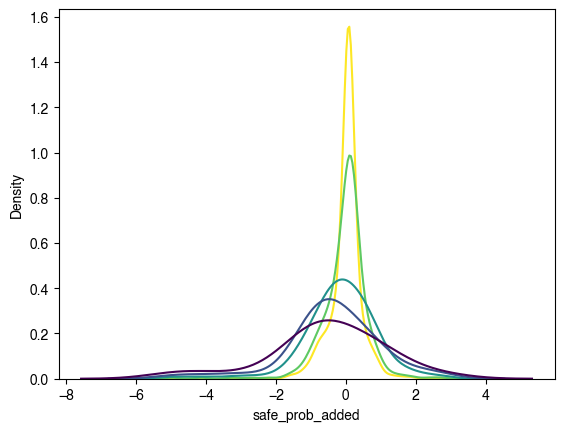

In [96]:
temp_1 = temp[temp['run_count'] >= 1]['safe_prob_added']
temp_2 = temp[temp['run_count'] >= 2]['safe_prob_added']
temp_4 = temp[temp['run_count'] >= 5]['safe_prob_added']
temp_8 = temp[temp['run_count'] >= 10]['safe_prob_added']
temp_16 = temp[temp['run_count'] >= 20]['safe_prob_added']

cmap = plt.get_cmap(name='viridis')
colors = [cmap(i) for i in np.linspace(0,1,5)]

import seaborn as sns
sns.kdeplot(temp_1, color=colors[4])
sns.kdeplot(temp_2, color=colors[3])
sns.kdeplot(temp_4, color=colors[2])
sns.kdeplot(temp_8, color=colors[1])
sns.kdeplot(temp_16, color=colors[0])